## **4. Keywords Clustering** (sklearn)

https://colab.research.google.com/drive/1HHNFjKlip1AaFIuvvn0AicWyv6egLOZw?usp=sharing#scrollTo=zhP1daroRzRV  
(Une approche à base de Word embedding - on pourrait utiliser les scores TF-IDF ou OKapi pour les traits discriminants plutôt que la fréquence (voir plus bas))

In [27]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
import matplotlib.pyplot as plt

Importer la liste de termes candidats avec leur fréquence

In [28]:
path = '../05-transformation/'
acteur = 'msss'
tag = 'deficiences-et-handicaps'

csv_file = acteur + '_' + tag + '_weighting_OKapiBM25.csv'

In [29]:
from pandas import *

with open(path+csv_file, encoding='utf-8') as f:
    keywords = read_csv(f).drop(columns = ['Unnamed: 0'])[['Terme', 'Fréquence (TF)', 'Fréquence documentaire (DF)']]
    keywords['TF + DF']= keywords['Fréquence (TF)'] + keywords['Fréquence documentaire (DF)']
keywords

,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF
0,services psychosociaux pour les jeunes en diff...,24,4,28
1,contrôle de l'environnement et à la technologi...,24,24,48
2,forum québécois sur le trouble du spectre de l...,53,34,87
3,heures de service de soutien à domicile,24,6,30
4,réseau de la santé et des services sociaux,33,19,52
...,...,...,...,...
605,accompagnement,24,15,39
606,alimentation,107,49,156
607,nombre,218,62,280
608,environnement,121,34,155


In [30]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer("(\w+\'|\w+-\w+|\(|\)|\w+)")

file_path = "../04-filtrage/stopwords.txt"
with open(file_path, 'r', encoding="utf-8") as f:
    stopwords = [t.lower().strip('\n') for t in f.readlines()]

def to_tokens(kw, min_chars=2):
    """
    Transforms sentence to list of tokens.  

    Basic: transform special characters to ascii + lowercase.  
    Options:  
    - remove stopwords (provide list of stopwords)  
    - set minimum length for tokens: will remove any shorter token. 
    
    Returns sorted tokens
    """
    tokens = tokenizer.tokenize(kw) # split the string into a list of words
    tokens = [word for word in tokens if len(word) > min_chars] 
    tokens = [word for word in tokens if word not in stopwords] 
    
    tokens = set(tokens) # to remove duplicates
    tokens = sorted(tokens) # converts our set back to a list and sorts words in alphabetical order
    return tokens

In [36]:
keywords["tokens"] = keywords["Terme"].apply(lambda x: to_tokens(
    x,
    min_chars=2,
))

## Test - ça fait pas beaucoup de sens de cluster des unigrammes
keywords["len"] = keywords["tokens"].apply(lambda x : len(x))
keywords = keywords[keywords['len'] > 1].drop(columns=["len"])

In [37]:
keywords

,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,tokens
0,services psychosociaux pour les jeunes en diff...,24,4,28,"[difficulté, jeunes, psychosociaux, services]"
1,contrôle de l'environnement et à la technologi...,24,24,48,"[bluetooth, contrôle, environnement, technologie]"
2,forum québécois sur le trouble du spectre de l...,53,34,87,"[autisme, forum, québécois, spectre, trouble]"
3,heures de service de soutien à domicile,24,6,30,"[domicile, heures, service, soutien]"
4,réseau de la santé et des services sociaux,33,19,52,"[réseau, santé, services, sociaux]"
...,...,...,...,...,...
530,source d'alimentation,24,24,48,"[alimentation, source]"
531,périodes disponibles,28,28,56,"[disponibles, périodes]"
532,plan d'intervention,20,8,28,"[intervention, plan]"
536,gestionnaire principal,46,36,82,"[gestionnaire, principal]"


In [38]:
from collections import Counter

vocab = sorted(set(keywords["tokens"].explode()))
len(vocab)

counter = Counter(keywords["tokens"].explode().to_list())
vocab = []

# Ici, ça serait intéressant de retenir sur la base du score TF-IDF ou OKapi
for key,value in counter.most_common(50):
    vocab.append(key)
len(vocab)

50

In [39]:
def to_vector(keyword,vocab):
    """
    Calculates vector of keyword on given vocabulary.

    Returns vector as a list of values.  
    """
    vector = []
    for word in vocab:
        if word in keyword:
            vector.append(1)
        else:
            vector.append(0)
    return vector

keywords["vector"] = keywords["tokens"].apply(lambda x: to_vector(x,vocab))
keywords

,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,tokens,vector
0,services psychosociaux pour les jeunes en diff...,24,4,28,"[difficulté, jeunes, psychosociaux, services]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,contrôle de l'environnement et à la technologi...,24,24,48,"[bluetooth, contrôle, environnement, technologie]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,forum québécois sur le trouble du spectre de l...,53,34,87,"[autisme, forum, québécois, spectre, trouble]","[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
3,heures de service de soutien à domicile,24,6,30,"[domicile, heures, service, soutien]","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,réseau de la santé et des services sociaux,33,19,52,"[réseau, santé, services, sociaux]","[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
530,source d'alimentation,24,24,48,"[alimentation, source]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ..."
531,périodes disponibles,28,28,56,"[disponibles, périodes]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
532,plan d'intervention,20,8,28,"[intervention, plan]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
536,gestionnaire principal,46,36,82,"[gestionnaire, principal]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [40]:
kmeans = KMeans(n_clusters = 10, random_state=0, algorithm='elkan').fit(keywords["vector"].to_list())
keywords["Cluster"] = list(kmeans.labels_)

Méthode Elbow


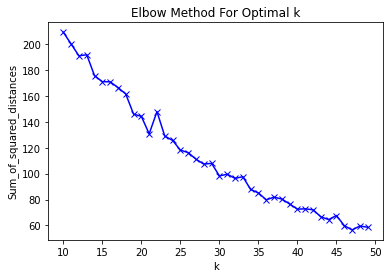

Score Silhouette
On va regrouper nos termes en 18 clusters.


,Nombre de clusters (k),Score Silhouette
0,10,0.622601
1,11,0.642045
2,12,0.584194
3,13,0.554194
4,14,0.577594
5,15,0.641410
6,16,0.631957
7,17,0.632951
8,18,0.659679
9,19,0.652198


In [41]:
K = range(10,50)
Sum_of_squared_distances = []
silhouette_scores = []

for k in K:
    #true_k = int(input())
    X = keywords["vector"].to_list()
    kmeans = KMeans(n_clusters=k, init='k-means++', algorithm='elkan', max_iter=200, n_init=1).fit(X)
    Sum_of_squared_distances.append(kmeans.inertia_)

    # Run LSA
    # Since LSA/SVD results are not normalized,
    # we redo the normalization to improve the k-means result.
    svd = TruncatedSVD(n_components=k)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)
    kmeans.fit(X)

    labels = kmeans.labels_
    #keywords["Cluster"] = list(kmeans.labels_)

    original_space_centroids = svd.inverse_transform(X)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    silhouette_scores.append([k, metrics.silhouette_score(X, labels)])

df = DataFrame(silhouette_scores, columns=['Nombre de clusters (k)', 'Score Silhouette'])
true_k = int(df[df['Score Silhouette'] == df['Score Silhouette'].max()]['Nombre de clusters (k)'])

print("Méthode Elbow")
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

print("Score Silhouette")
print("On va regrouper nos termes en " + str(true_k) + " clusters.")
df

In [42]:
print('Number of clusters used (K) = ' + str(true_k))
kmeans = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=1)

# Run LSA
# Since LSA/SVD results are not normalized,
# we redo the normalization to improve the k-means result.
svd = TruncatedSVD(n_components=true_k)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)
kmeans.fit(X)

labels=kmeans.labels_
keywords["Cluster"] = list(kmeans.labels_)

keywords

Number of clusters used (K) = 18


,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,tokens,vector,Cluster
0,services psychosociaux pour les jeunes en diff...,24,4,28,"[difficulté, jeunes, psychosociaux, services]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4
1,contrôle de l'environnement et à la technologi...,24,24,48,"[bluetooth, contrôle, environnement, technologie]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10
2,forum québécois sur le trouble du spectre de l...,53,34,87,"[autisme, forum, québécois, spectre, trouble]","[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...",13
3,heures de service de soutien à domicile,24,6,30,"[domicile, heures, service, soutien]","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",17
4,réseau de la santé et des services sociaux,33,19,52,"[réseau, santé, services, sociaux]","[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7
...,...,...,...,...,...,...,...
530,source d'alimentation,24,24,48,"[alimentation, source]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...",5
531,périodes disponibles,28,28,56,"[disponibles, périodes]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
532,plan d'intervention,20,8,28,"[intervention, plan]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
536,gestionnaire principal,46,36,82,"[gestionnaire, principal]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",2


Apposer un label approprié aux cluster

In [43]:
current_labels = set(kmeans.labels_.tolist())

desired_labels = {x : None for x in current_labels} # (on initialise à None)
for label in current_labels:
    cluster = keywords[keywords["Cluster"] == label]
    max_freq = cluster['TF + DF'].max()
    new_label = cluster[cluster['TF + DF'] == max_freq]['Terme'].values[0]

    desired_labels[label] = new_label

In [ ]:
# keywords.to_csv('../06-clustering/' + acteur + '_clusters-K-means.csv')

In [44]:
current_labels = set(kmeans.labels_.tolist())

desired_labels = {x : None for x in current_labels} ### To change
for label in current_labels:
    cluster = keywords[keywords["Cluster"] == label]
    max_freq = cluster['TF + DF'].max()
    new_label = cluster[cluster['TF + DF'] == max_freq]['Terme'].values[0]

    desired_labels[label] = new_label

In [45]:
desired_labels = {x : None for x in current_labels} ### To change
for label in current_labels:
    cluster = keywords[keywords["Cluster"] == label]
    max_freq = cluster['TF + DF'].max()
    new_label = cluster[cluster['TF + DF'] == max_freq]['Terme'].values[0]

    desired_labels[label] = new_label

keywords['Cluster'] = keywords['Cluster'].map(desired_labels)

In [46]:
keywords = keywords[['Terme', 'Fréquence (TF)', 'Fréquence documentaire (DF)', 'Cluster']]
keywords.sort_values(["Cluster"], 
        axis=0,
        ascending=[False], 
        inplace=True)

C:\Users\p1115145\AppData\Local\Temp\ipykernel_14832\4128668333.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords.sort_values(["Cluster"],


In [47]:
keywords

,Terme,Fréquence (TF),Fréquence documentaire (DF),Cluster
57,trouble envahissant du développement,24,14,trouble du spectre de l'autisme
25,déficience intellectuelle et trouble du spectre,63,37,trouble du spectre de l'autisme
48,trouble du spectre de l'autisme,235,82,trouble du spectre de l'autisme
84,déficience intellectuelle et trouble,65,39,trouble du spectre de l'autisme
333,forum québécois,53,34,trouble du spectre de l'autisme
...,...,...,...,...
50,suppléance à la communication,19,14,aides techniques
43,programme ministériel des aides techniques,17,17,aides techniques
30,aides techniques à la communication,36,22,aides techniques
15,sce sur appareil numérique,48,10,aides techniques


In [48]:
keywords.groupby("Cluster")["Terme"].count()

Cluster
aides techniques                                 15
cadre normatif                                    8
contrôle de l'environnement                       8
disponibilité des données et résultats           15
déficience physique                               9
fin de la période                                 7
ministère de la santé et des services sociaux    11
modes d'accès                                     7
nombre d'usagers                                  8
profil d'intervention                             7
projet pilote                                    73
régie de l'assurance maladie                      5
répertoire des indicateurs de gestion             7
services sociaux                                 28
soutien à domicile                               15
soutien à l'autonomie des personnes âgées         8
spectre de l'autisme                             11
trouble du spectre de l'autisme                  10
Name: Terme, dtype: int64

---------------  
Visualisation 
--------------  

In [ ]:
from sklearn.decomposition import PCA

vectors = keywords["vector"].to_list()

pca = PCA(n_components=2).fit(vectors)
pca_2d = pca.transform(vectors)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(pca_2d[:,0], pca_2d[:,1], c=keywords["kmeans"])

In [ ]:
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=keywords["kmeans"], s=keywords["Fréquence (TF)"])

In [ ]:
from collections import Counter

counter = Counter(keywords["tokens"].explode().to_list())
vocab = []
for key,value in counter.most_common(100):
    vocab.append(key)
len(vocab)

In [ ]:
keywords["vector"] = keywords["tokens"].apply(lambda x: to_vector(x,vocab))
pca = PCA(n_components=2).fit(keywords["vector"].to_list())
pca_2d = pca.transform(keywords["vector"].to_list())

kmeans = KMeans(n_clusters = 3, random_state=0).fit(keywords["vector"].to_list())
keywords["kmeans"] = list(kmeans.labels_)

plt.scatter(pca_2d[:,0], pca_2d[:,1], c=keywords["kmeans"], s=keywords["Fréquence (TF)"])